# Singular value decomposition for image processing

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from sklearn.datasets import fetch_olivetti_faces

import gdown

## Data

In [ ]:
!rm -rf yale_face
!rm -rf img_align_celeba
gdown.download("https://drive.google.com/uc?id=1AwKHDT4W9vs6TQNCsebHjwa7QKCbpsPZ", "yale_face.zip")
gdown.download("https://drive.google.com/uc?id=1Bi6UsHMUmd4iqCwVWlKeLgf4HgT9PMfr", "celeba.zip")
!unzip -q yale_face.zip
!unzip -q celeba.zip
!mv img_align_celeba celeba

Downloading...
From: https://drive.google.com/uc?id=1AwKHDT4W9vs6TQNCsebHjwa7QKCbpsPZ
To: /content/yale_face.zip
100%|██████████| 55.7M/55.7M [00:01<00:00, 52.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Bi6UsHMUmd4iqCwVWlKeLgf4HgT9PMfr
To: /content/celeba.zip
100%|██████████| 1.44G/1.44G [00:09<00:00, 156MB/s]


In [ ]:
data_type = "celeba"  # yale, celeba

if data_type == "yale":
    root = "./yale_face"
    files = sorted(os.listdir(root))
    files_test = None
    shape = (48, 42)  # Size can be changed, e.g., (96, 84) or (192, 168)
elif data_type == "celeba":
    root = "./celeba"
    files = sorted(os.listdir(root))
    files_test = files[10000:11000]
    files = files[:10000]
    shape = (54, 44)

images = []
for file in tqdm(files):
    image = Image.open(f"{root}/{file}")
    image = image.resize(shape[::-1])
    image = np.asarray(image).astype(np.float32) / 255
    images.append(image)
images = np.stack(images, axis=0)
num_images = images.shape[0]
image_shape = images.shape[1:]
print(f"We have {num_images} of shape {image_shape}.")

if files_test is not None:
    images_test = []
    for file in tqdm(files_test):
        image = Image.open(f"{root}/{file}")
        image = image.resize(shape[::-1])
        image = np.asarray(image).astype(np.float32) / 255
        images_test.append(image)
    images_test = np.stack(images_test, axis=0)
    num_images_test = images_test.shape[0]
    print(f"We have (test) {num_images_test} of shape {image_shape}.")
else:
    images_test = None

In [ ]:
def imshow(image, shape=image_shape, vmin=0, vmax=1, dpi=72, cmap="gray"):
    plt.figure(dpi=dpi)
    plt.axis("off")
    if shape is not None:
        image = np.reshape(image, shape)
    if vmin is None:
        vmin = image.min()
    if vmax is None:
        vmax = image.max()
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)

In [ ]:
def imshow_sequence(images, normalize=False, shape=image_shape, idxs=None, sort=True, title=True,
                    dpi=72, **kwargs):
    if type(images) in (tuple, list):
        images = np.stack(images, axis=0)
    if type(idxs) == int:
        idxs = np.random.choice(len(images), idxs)
        if sort:
            idxs.sort()
    elif idxs is None:
        idxs = list(range(len(images)))
    images_show = images[idxs]

    fig, axs = plt.subplots(1, len(images_show), figsize=(20, 20), dpi=dpi)
    for i in tqdm(range(images_show.shape[0])):
        image = images_show[i]
        if shape is not None:
            image = np.reshape(image, shape)
        if type(title) in (tuple, list):
            axs[i].title.set_text(title[i])
        elif title:
            axs[i].title.set_text(f"$i = {idxs[i]}$")
        axs[i].axis("off")
        if normalize:
            image = (image - image.min()) / (image.max() - image.min())
        axs[i].imshow(image, **kwargs)

  0%|          | 0/8 [00:00<?, ?it/s]

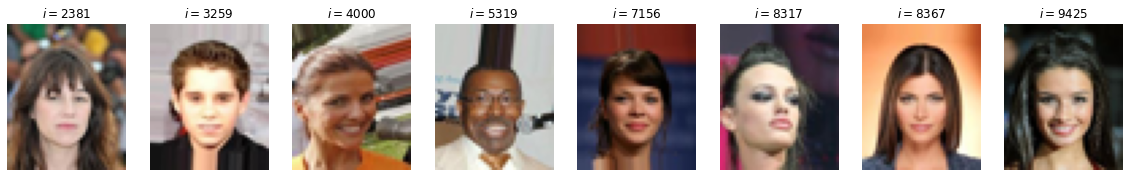

In [ ]:
imshow_sequence(images, idxs=8, vmin=0, vmax=1, cmap=None)  # A selection of dataset images

## Singular value decomposition

In [ ]:
D = np.reshape(images, (images.shape[0], -1)).T
print(f"We flatten the images to {D.shape[0]}-dimensional vectors. "
      "They are now column vectors of D.")

if images_test is not None:
    D_test = np.reshape(images_test, (images_test.shape[0], -1)).T

We flatten the images to 7128-dimensional vectors. They are now column vectors of D.


In [ ]:
D_mean = np.mean(D, axis=1)[:, None]
D_tilde = D - D_mean  # Mean-center D

The singular value decomposition (SVD) decomposes our dataset $\boldsymbol{D}$ (or more precisely, the mean-centered $\tilde{\boldsymbol{D}}$), into
$$ \boldsymbol{D} = \boldsymbol{U} \boldsymbol{\Sigma} \boldsymbol{V}^T . $$
Particularly, $\boldsymbol{D} \in \mathbb{R}^{d \times n}$, where $d$ is dimensions (i.e., number of pixels) in one image and $n$ is the number of images, so the images are column vectors of $\boldsymbol{D}$. We are primarily interested in $\boldsymbol{U} \in \mathbb{R}^{d \times d}$, as the column vectors of $\boldsymbol{U}$ are the eigenfaces of $\boldsymbol{D}$ in order of decreasing singular values, i.e., importance.

In [ ]:
%%time

U, S, VT = linalg.svd(D_tilde)  # Can take a while

CPU times: user 8min 35s, sys: 26.9 s, total: 9min 2s
Wall time: 5min 15s


In [ ]:
# The column vectors of U is our collection of eigenfaces. We reshape U into U_show so U_show can be
# directly displayed as the eigenfaces.
U_show = np.reshape(U.T, (U.shape[0],) + image_shape)
V = VT.T  # Technically SVD actually outputs V^T, so we transpose it back here

In [ ]:
print(f"Results of SVD: U is {U.shape}, S is {S.shape}, and V is {V.shape}")

Results of SVD: U is (7128, 7128), S is (7128,), and V is (10000, 10000)


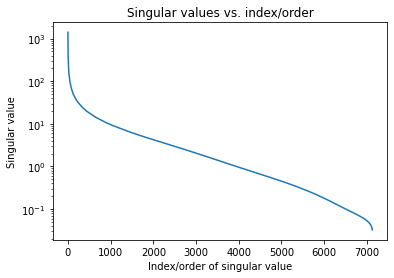

In [ ]:
plt.plot(S)
plt.title("Singular values vs. index/order")
plt.xlabel("Index/order of singular value")
plt.ylabel("Singular value")
plt.yscale("log")

You can see how the first few eigenfaces, i.e., column vectors of $\boldsymbol{U}$, represents global features of the dataset, e.g., lighting.

  0%|          | 0/10 [00:00<?, ?it/s]

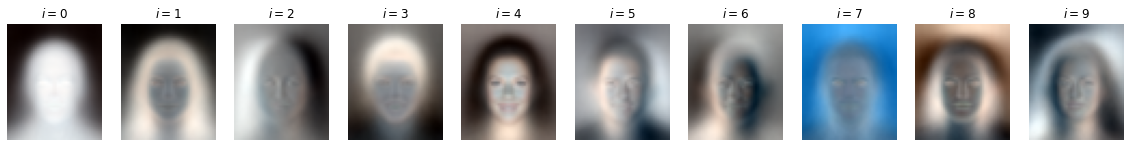

In [ ]:
imshow_sequence(U_show, normalize=True, idxs=list(range(10)), cmap=None)  # The first 8 eigenfaces

You can also see how, as we move from the first eigenfaces (higher singular values) to the last eigenfaces (lower singular values), the eigenfaces begin to represent fine details instead of global features.

  0%|          | 0/13 [00:00<?, ?it/s]

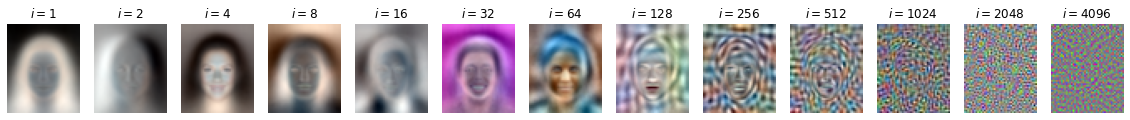

In [ ]:
imshow_sequence(U_show, normalize=True, idxs=[pow(2, i) for i in range(13)], cmap=None)

## Projection & Reconstruction

In [ ]:
def extract_from_D(D, i, column=True):
    """Extracts the i^th column vector from D, column=True keeps it as a column vector."""
    if column:
        x = D[:, i:i + 1]
    else:
        x = D[:, i]
    return x

In [ ]:
def projection(x, U):
    """Projects x into the column space of U, i.e., write x as linear combination of U."""
    if len(x.shape) == 1:  # Make x a column vector
        x = np.expand_dims(x, axis=1)
    x = x - D_mean
    # We are leaving the left-mulplication of linalg.inv(U.T @ U) since U is orthogonal and thus
    # U^T U = I, and the inverse of I is still I
    a = U.T @ x
    return a

In [ ]:
def reconstruction(a, U):
    """Given the coefficients a, reconstruct x with the column vectors of U."""
    if len(a.shape) == 1:  # Make a a column vector
        a = np.expand_dims(a, axis=1)
    x_hat = U @ a
    x_hat = x_hat + D_mean
    return x_hat

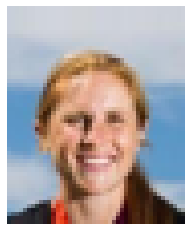

In [ ]:
x_test = extract_from_D(D_test, 155)
imshow(x_test, cmap=None)

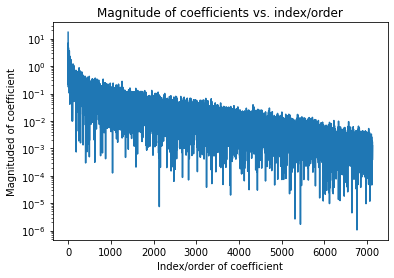

In [ ]:
x_coefficients = projection(x_test, U)  # The image should be perfectly reconstructed!

plt.plot(np.abs(x_coefficients))
plt.title("Magnitude of coefficients vs. index/order")
plt.xlabel("Index/order of coefficient")
plt.ylabel("Magnituded of coefficient")
plt.yscale("log")

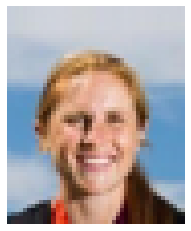

In [ ]:
x_reconstructed = reconstruction(x_coefficients, U)
imshow(x_reconstructed)

## Compression

  0%|          | 0/10 [00:00<?, ?it/s]

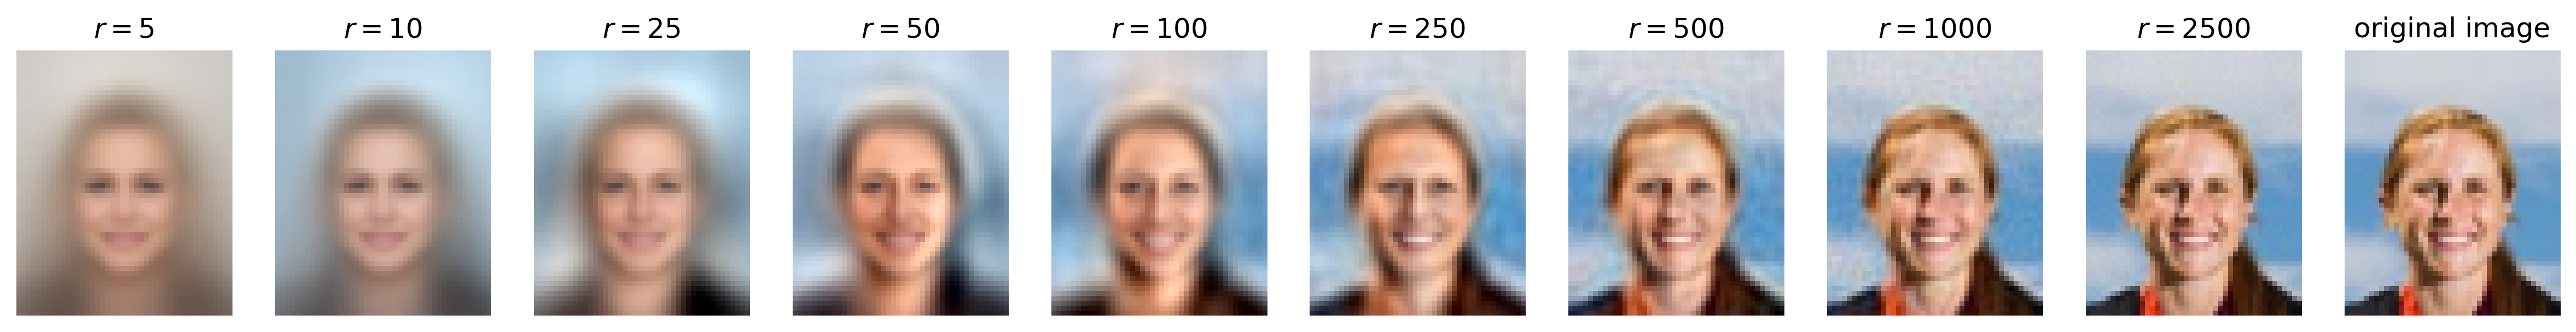

In [ ]:
x_reconstructed = []
title = []
for r in [5, 10, 25, 50, 100, 250, 500, 1000, 2500]:
    x_coefficients_compressed = np.copy(x_coefficients)
    x_coefficients_compressed[r:] = 0.0
    x_reconstructed.append(reconstruction(x_coefficients_compressed, U))
    title.append(f"$r = {r}$")

imshow_sequence(x_reconstructed + [x_test], title=title + ["original image"],
                cmap=None, dpi=300)

## Interpolation

In [ ]:
def slerp(c_1, c_2, alpha, normal=None, mode="linear"):
    assert c_1.shape == c_2.shape
    if normal is not None:
        normal = np.reshape(normal, c_1.shape)
        c_1 = c_1 / normal
        c_2 = c_2 / normal
    if mode == "linear":
        c_slerp = (1 - alpha) * c_1 + alpha * c_2
    elif mode == "spherical":
        theta = np.arccos(np.sum(c_1 * c_2) / (linalg.norm(c_1) * linalg.norm(c_2)))
        c_slerp = (np.sin((1 - alpha) * theta) / np.sin(theta)) * c_1 +\
                  (np.sin(alpha * theta) / np.sin(theta)) * c_2
    else:
        raise NotImplementedError(mode)
    if normal is not None:
        c_slerp = c_slerp * normal
    return c_slerp

In [ ]:
def interpolation(x_1, x_2, U, num_alphas=10, normal=None, mode="linear"):
    alphas = np.linspace(0.0, 1.0, num=num_alphas)
    c_1 = projection(x_1, U)
    c_2 = projection(x_2, U)
    x_interpolated = []
    for alpha in alphas:
        c_slerp = slerp(c_1, c_2, alpha, normal=normal, mode=mode)
        x_slerp = reconstruction(c_slerp, U)
        x_interpolated.append(x_slerp)
    return x_interpolated

  0%|          | 0/2 [00:00<?, ?it/s]

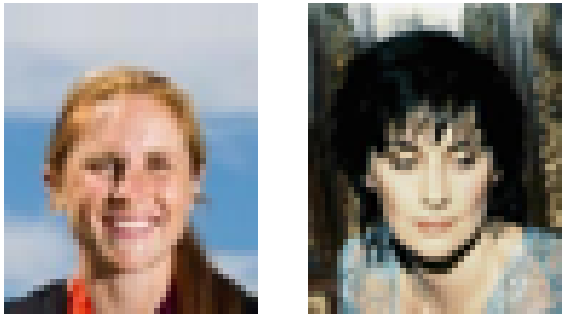

In [ ]:
x_test_1 = extract_from_D(D_test, 155)
x_test_2 = extract_from_D(D_test, 115)

imshow_sequence([x_test_1, x_test_2], cmap="gray", title=False, dpi=36)

  0%|          | 0/10 [00:00<?, ?it/s]

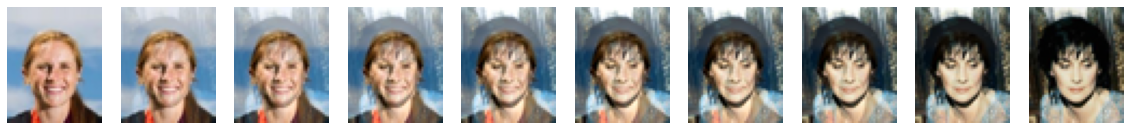

In [ ]:
x_test_interpolated = interpolation(x_test_1, x_test_2, U, num_alphas=10, normal=S, mode="spherical")
imshow_sequence(x_test_interpolated, cmap="gray", title=False, dpi=72)

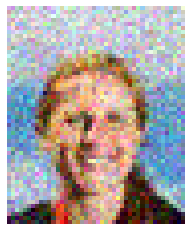

In [ ]:
x_test_1_noised = x_test_1 + 0.1 * np.random.randn(*x_test_1.shape)
imshow(x_test_1_noised)

  0%|          | 0/10 [00:00<?, ?it/s]

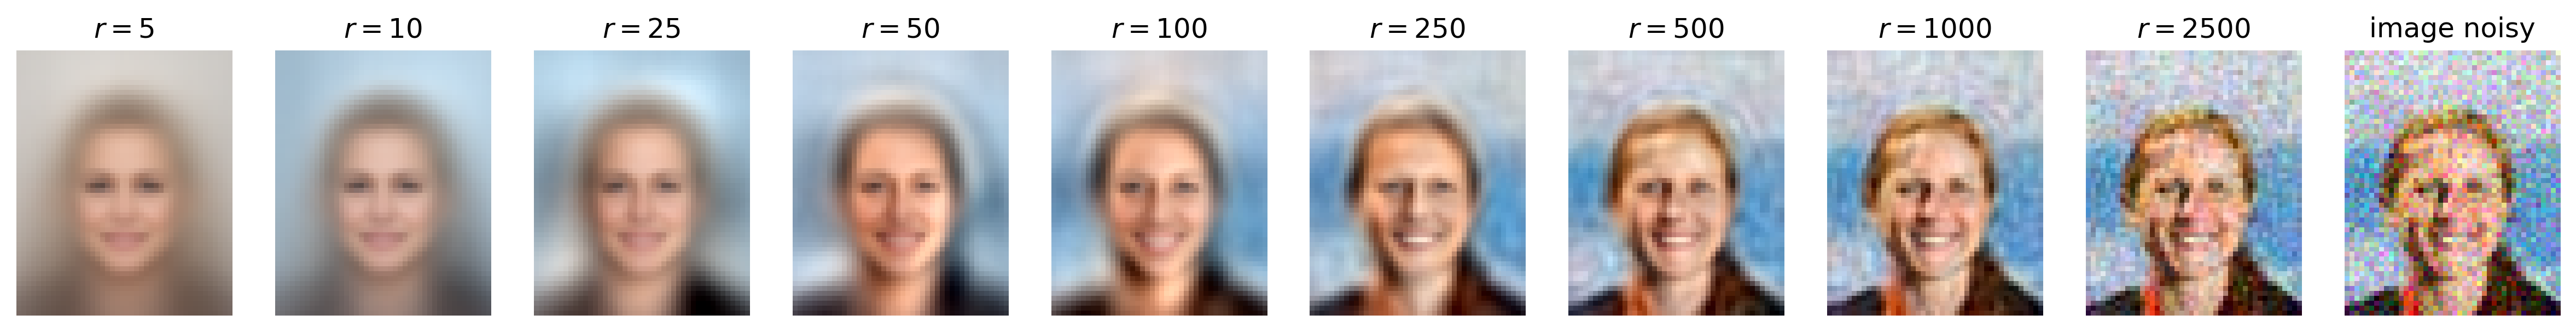

In [ ]:
x_test_1_coefficients = projection(x_test_1_noised, U)

x_reconstructed = []
title = []
for r in [5, 10, 25, 50, 100, 250, 500, 1000, 2500]:
    x_coefficients_compressed = np.copy(x_test_1_coefficients)
    x_coefficients_compressed[r:] = 0.0
    x_reconstructed.append(reconstruction(x_coefficients_compressed, U))
    title.append(f"$r = {r}$")

imshow_sequence(x_reconstructed + [x_test_1_noised], title=title + ["image noisy"],
                cmap=None, dpi=300)